## Generate 2 canyon bathymetry with Astoria dimensions

Thanks Idalia for your awesome make_mackenzie notebook :-) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import time
from scipy.interpolate import interp1d

%matplotlib inline

import canyon_tools.bathy_tools as bat
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_style('dark')

In [3]:
def tanktopo(y, y_base, y_break, y_head, y_shallow,
             fluid_depth, z_bottom, z_break, z_head, z_shallow):
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    sls_ct = (z_shallow - z_head) / (y_shallow - y_head)
    sls_ch = (z_head - z_break) / (y_head - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
        
        elif y[jj] > y_break and y[jj] <= y_head:
            topo_sp[jj] = (sls_ch * y[jj]) - (sls_ch * y_break) + z_break
                    
        elif y[jj] > y_head and y[jj] <= y_shallow:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_head) + z_head
                                  
        elif y[jj] > y_shallow:
            topo_sp[jj] = z_shallow

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile

#----------------------------------------------------------------------------------

def canyontopo(y, y_base, y_break, y_head, y_shallow,
               fluid_depth, z_bottom, z_break, z_head, z_shallow):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    slc_L = (z_head - z_bottom) / (y_head - y_base)
    slc_ct = (z_shallow - z_head) / (y_shallow - y_head)
    
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_shallow :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_head
          
        elif y[ii] > y_shallow:
            topo_cp[ii] = z_shallow
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile
#----------------------------------------------------------------------------------
   
def widthprofile(y, y_base, y_break, y_head, y_shallow, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_shallow:
                wp[l] = wp[l-1]
            
            elif y[l] > y_shallow:
                wp[l] = w_break
                
                
        
    width_profile = wp 
    return width_profile
#----------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_break, y_head, y_shallow, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p, C,
                     fluid_depth, z_bottom, z_break, z_shallow, z_head, z_wall):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_head, y_shallow, fluid_depth, z_bottom, z_break, z_head, z_shallow)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_shallow,fluid_depth, z_bottom, z_break, z_head, z_shallow)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_shallow, cR, L,
                                 w_break, w_mid, w_head, p)
    
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**C))
    #topography=np.transpose(topography)
    topo = -1* topography[0:, :]
    
    return topo
#----------------------------------------------------------------------------------

def make_flat_shelf(x, y, y_base, y_break, y_head, y_shallow, fluid_depth, z_bottom, z_break, z_head, z_shallow):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_head, y_shallow, fluid_depth, z_bottom, z_break, z_head, z_shallow)
    
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (canyondepth)
    topo = -1* topography[0:, :]
    
    return topo
#----------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y

    
#----------------------------------------------------------------------------------

def define_dimensions():
    ''' This function defines all dimensions that are used to create 
    the bathymetry profile.
    '''
    
    # Alongshore
    w_break = 15.7E3 # m 
    w_mid = 8.9E3  
    w_head = 3.0E3 
    width_f = 15.7E3
    x_wall = 120E3#width_f * 7

    # Adjustments
    y_wall = 110E3 # (mouth + length) * 2.0
    
    # Cross-shore
    cR = 4.5E3
    L = 21.8E3     
    y_base = 20.0E3  # where slope starts rising
    y_break = 45.0E3 # shelf break distance 
    y_shallow = y_break+56.5E3#90E3
    y_head = y_break + L # canyon head location

    # Depths
    Hs = 150
    Hh = 100
    Hshallow = 20
    fluid_depth = 1200 #1300.0
    z_bottom = fluid_depth - fluid_depth
    z_break = fluid_depth - Hs
    z_wall = fluid_depth
    z_head = fluid_depth - Hh
    z_shallow = fluid_depth-Hshallow
    p = 4
    C = 25
    return w_break, w_mid, w_head, width_f, x_wall, y_wall, \
            cR, L, y_base, y_break, y_shallow, y_head,\
            fluid_depth, z_bottom, z_break, z_wall,z_head,z_shallow, p, C, Hs, Hh

In [4]:
w_break, w_mid, w_head, width_f, x_wall,y_wall,cR,\
L, y_base, y_break, y_shallow, y_head,fluid_depth,\
z_bottom, z_break, z_wall,z_head,z_shallow, p,C, Hs, Hh = define_dimensions()


In [5]:
xsize = 360
ysize = 360
xlin, ylin, y_edge, X, Y = set_domain_grid(xsize, ysize, x_wall, y_wall)

In [6]:
shelf_shape = tanktopo(ylin, y_base, y_break, y_head, y_shallow, fluid_depth, z_bottom, z_break, z_head, z_shallow)
   
shelf = np.expand_dims(shelf_shape, axis=0) + np.zeros(np.shape(X))

canyon_axis = canyontopo(ylin, y_base, y_break, y_head, y_shallow,fluid_depth, z_bottom, z_break, z_head, z_shallow)

width_profile = widthprofile(ylin, y_base, y_break, y_head, y_shallow, cR, L, w_break, w_mid, w_head, p)


bathymetry = make_topo_smooth(ylin, y_base, y_break, y_head, y_shallow, cR, L,
                              xlin, x_wall, w_break, w_mid, w_head, p, C,
                              fluid_depth, z_bottom, z_break, z_shallow, z_head, z_wall)

Text(0.5,1,'Width profile')

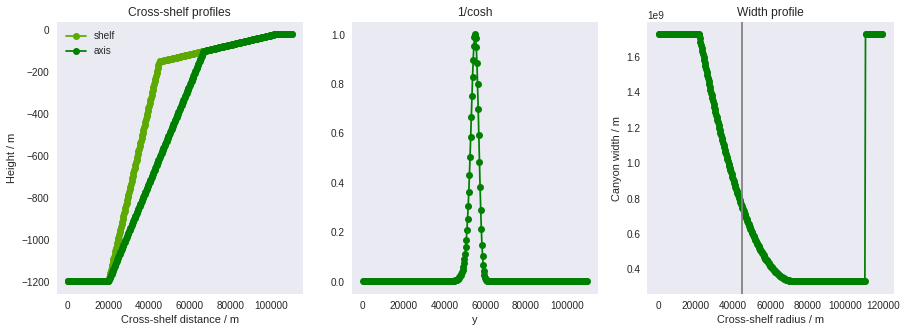

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,5))


ax[0].plot(ylin,shelf_shape, 'o-', color=sns.xkcd_rgb['leaf green'], label = 'shelf')
ax[0].plot(ylin,canyon_axis, 'go-', label = 'axis')
ax[0].set_xlabel('Cross-shelf distance / m')
ax[0].set_ylabel('Height / m')
ax[0].set_title('Cross-shelf profiles')
ax[0].legend(loc=0)

ax[1].plot(ylin, 1.0 / ((np.cosh(0.4/ (width_profile) * (ylin-y_wall/2)))**C), 'go-', label = 'shelf')

ax[1].set_xlabel('y')
ax[1].set_ylabel(' ')
ax[1].set_title('1/cosh')

ax[2].plot(xlin, width_profile*y_wall, 'go-')
ax[2].axvline(y_break,color='0.5')
ax[2].set_xlabel('Cross-shelf radius / m')
ax[2].set_ylabel('Canyon width / m')
ax[2].set_title('Width profile')



W_sb is 15700.0 m
W_sb is 8900.0 m
Depth  of shelf break is 150.0 m
Canyon length sb depth is 21800.0 m


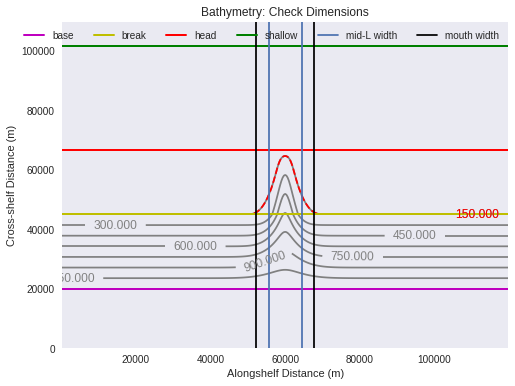

In [8]:
sns.set_context('notebook')
sns.set_style('dark')
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title('Bathymetry: Check Dimensions')
ax.set_xlabel('Alongshelf Distance (m)'); ax.set_ylabel('Cross-shelf Distance (m)')
cs = ax.contour(X, Y, bathymetry, 10, colors='grey', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [Hs], colors='red',linestyles='--')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

# markers
ys = [y_base, y_break, y_head, y_shallow]
labs = ['base', 'break', 'head', 'shallow']
cs = ['m', 'y', 'r', 'g']
for i, j, k in zip(ys, labs, cs):
    ax.axhline(i, c=k, label=j, linewidth=2)
ax.axvline((x_wall/2)-(w_mid/2)); plt.axvline((x_wall/2)+(w_mid/2), label='mid-L width')
ax.axvline((x_wall/2)+(w_break/2), c='k'); plt.axvline((x_wall/2)-(w_break/2), c='k', label='mouth width')
ax.legend(ncol=7)
#ax.set_ylim(0,0.5)
print('W_sb is %1.1f m' %w_break)
print('W_sb is %1.1f m' %w_mid)
print('Depth  of shelf break is %1.1f m' %Hs)
print('Canyon length sb depth is %1.1f m' %L)

L bathy is 21800.0 m
L for scaling is is 21800.0 m
L_scaling-L_bathy =  0.0 m


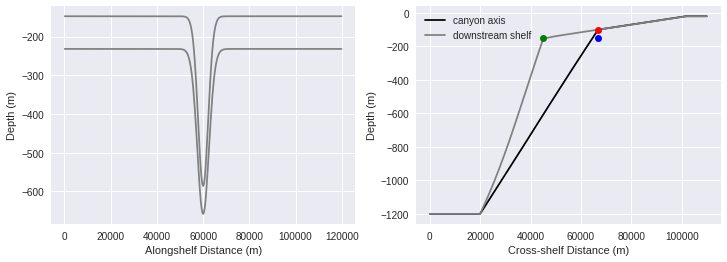

In [9]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_xlabel('Alongshelf Distance (m)'); ax1.set_ylabel('Depth (m)')
cs = ax1.plot(X[140,:], -bathymetry[140,:], color='grey', linestyle='solid')
cs = ax1.plot(X[150,:], -bathymetry[150,:], color='grey', linestyle='solid')

ax2.set_xlabel('Cross-shelf Distance (m)'); ax2.set_ylabel('Depth (m)')
ax2.plot(Y[:,180], -bathymetry[:,180], color='black', label='canyon axis')
ax2.plot(Y[:,200], -bathymetry[:,200], color='grey', label='downstream shelf')
ax2.legend(loc=0)

ax2.plot(y_break,-Hs, 'og')
ax2.plot(y_break+L,-Hs, 'ob')
ax2.plot(y_head,-Hh, 'or')

print('L bathy is %1.1f m' %(L))
print('L for scaling is is %1.1f m' %(y_head-y_break))
print('L_scaling-L_bathy =  %1.1f m' %(y_head-y_break-L))



In [31]:
print(np.shape(X))

bathy_2can = np.zeros_like(bathymetry)
bathy_2can[:,0:100] = bathymetry[:,0:100]
bathy_2can[:,259:] = bathymetry[:,0:100]
bathy_2can[:,100:180] = bathymetry[:,140:220] 
bathy_2can[:,180:260] = bathymetry[:,140:220] 

(359, 359)


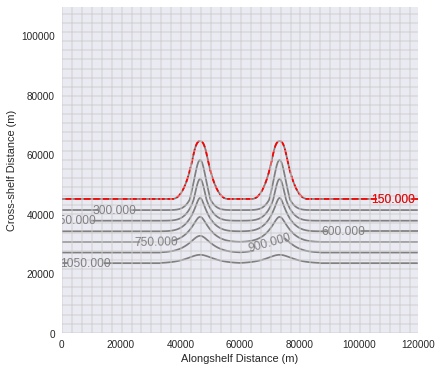

In [35]:
sns.set_context('notebook')
sns.set_style('dark')
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_title('')
ax.set_xlabel('Alongshelf Distance (m)'); ax.set_ylabel('Cross-shelf Distance (m)')

for xx in X[0,::10]:
    ax.axvline(xx, color='0.8', alpha=0.5)
for yy in Y[::10,0]:
    ax.axhline(yy, color='0.8', alpha=0.5)

cs = ax.contour(X, Y, bathy_2can, 10, colors='grey', linestyles='solid')
CS = ax.contour(X, Y, bathy_2can, levels = [Hs], colors='red',linestyles='--')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)


ax.set_aspect(1)

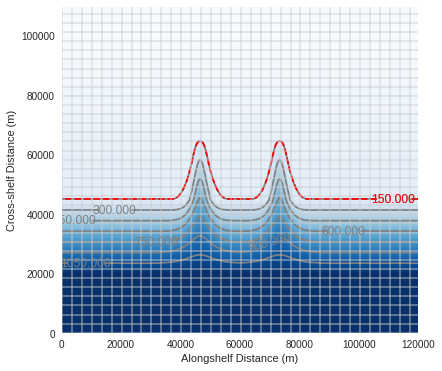

In [38]:
sns.set_context('notebook')
sns.set_style('dark')
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_title('')
ax.set_xlabel('Alongshelf Distance (m)'); ax.set_ylabel('Cross-shelf Distance (m)')

for xx in X[0,::10]:
    ax.axvline(xx, color='0.8', alpha=0.5)
for yy in Y[::10,0]:
    ax.axhline(yy, color='0.8', alpha=0.5)
ax.pcolormesh(X, Y, bathy_2can, cmap = 'Blues')
cs = ax.contour(X, Y, bathy_2can, 10, colors='grey', linestyles='solid')
CS = ax.contour(X, Y, bathy_2can, levels = [Hs], colors='red',linestyles='--')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)


ax.set_aspect(1)

### Save nc file

In [36]:
def create_bathy_file(X, Y, bathymetry, filename, title, description):
    
    """ This function creates a netCDF4 file for
    the canyon bathymetry given the filename and 
    the x and y grid cell number.
    
    :arg X: Alongshore indices (from set_domain_grid)
    :arg Y: Cross-shore indices (from set_domain_grid)
    :arg bathymetry: Canyon bathymetry (from make_topo_smooth)
    :arg filename: Directory and name of netcdf file
    :arg title: Title of bathymetry version
    :arg description: Details about bathymetry version
    """
    
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', X.shape[1])
    file_y = dataset.createDimension('y', X.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('y','x'))
    file_Y = dataset.createVariable('Y', 'f8', ('y','x'))
    Bathymetry = dataset.createVariable('Bathymetry', 'f8', ('y','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/CanyonsUBC/BuildCanyon/Bathymetry/bathy_2Canyons_Astoria.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Alongshelf Distance'
    file_X.units = 'm'
    file_Y.standard_name = 'Cross-shelf Distance'
    file_Y.units = 'm'
    Bathymetry.standard_name = 'Bathymetry'
    Bathymetry.units = 'm'
    Bathymetry.positive = 'upward'

    file_X[:] = X[:]
    file_Y[:] = Y[:]
    Bathymetry[:] = bathymetry[:]

    dataset.close()
    

In [37]:
create_bathy_file(X, Y, bathy_2can, 'bathy_2canyons_Astoria_dims.nc',
                  'Bathy to generate two canyon 3d bathy for schematics',
                  'Bathy to generate two canyon 3d bathy for schematics')